# Setup

In [47]:
import os
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy import signal
import glob

# For use in Google Colab
# from google.colab import auth
# auth.authenticate_user()
# from google.colab import drive
# from google.colab import files
# import gspread
# from oauth2client.client import GoogleCredentials
# drive.mount('/content/gdrive')

In [48]:
folder = 'Data/'
t_pre_onset = 3 # Time pre-movement
t_post_onset = 1 # Time post-movement

## Channel Locations

In [49]:
ch_locs = {1:'O1',
           2:'O2',
           3:'F7',
           4:'F3',
           5:'Fz',
           6:'F4',
           7:'T6',
           8:'T3',
           9:'C3',
           10:'Cz',
           11:'C4',
           12:'T4',
           13:'T5',
           14:'P3',
           15:'Pz',
           16:'right arm'}

## Session Object (sesh)

In [50]:
class method():
    def __init__(self, sesh_type='', mov_type=''):
        self.sesh_type = sesh_type
        self.mov_type = mov_type

class filt():
    def __init__(self, low_cut=-1234.123, high_cut=-1234.123, notch=-1234.123):
        self.low_cut = low_cut
        self.high_cut = high_cut
        self.notch = notch


class hrdwr():
    def __init__(self, gen_hrdwr='', spc_hrdwr='', elc_loc=[''], low_cut=-1234.123, high_cut=-1234.123, notch=-1234.123):
        self.gen_hrdwr = gen_hrdwr
        self.spc_hrdwr = spc_hrdwr
        self.filt = filt(low_cut=low_cut, high_cut=high_cut, notch=notch)
        self.elc_loc = elc_loc

class other():
    def __init__(self, ref='not specified', gnd='not specified', notes=[], data_quality=-1):
        self.ref = ref
        self.gnd = gnd
        self.notes = notes
        self.data_quality = data_quality

class sesh():
    def __init__(self, filename='', gen_hrdwr='', spc_hrdwr='', elc_loc=[], low_cut=-1234.123, high_cut=-1234.123, notch=-1234.123, sesh_type='', mov_type='', use=False, ref='not specified', gnd='not specified', data_quality=-1, notes=[], crop_start=0, threshold=0.0):
        self.filename = filename
        self.hrdwr = hrdwr(gen_hrdwr=gen_hrdwr, spc_hrdwr=spc_hrdwr, elc_loc=elc_loc, low_cut=low_cut, high_cut=high_cut, notch=notch)
        self.method = method(sesh_type=sesh_type, mov_type=mov_type)
        self.use = use
        self.other = other(notes=notes, ref=ref, gnd=gnd, data_quality=data_quality)
        self.crop_start = crop_start
        self.threshold = threshold

    def get_data_chns(self, debug=False):
        # Add data_chns to sesh object

        PATH = folder + self.filename
        if self.hrdwr.gen_hrdwr == 'OpenBCI':
            self.data_chns = []

            f = open(PATH)
            lines = []
            for i in f.readlines():
                lines.append(i)
            f.close()

            for i in range(1,4):
                if i == 1:
                    self.n_chns = int(lines[i].split()[-1])
                if i == 2:
                    self.sample_rate = int(lines[i].split()[-2])

            crop_start = self.crop_start # seconds

            for j in range(self.n_chns):
                this_data_ch = []
                if crop_start != 0:
                    for i in range(crop_start*self.sample_rate, len(lines)):
                        this_data_ch.append(float(lines[i].split(', ')[j+1]))
                    if j == self.n_chns - 1:
                        print('Cropped Data at ' + str(crop_start) + ' seconds')
                else:    
                    for i in range(5, len(lines)):
                        this_data_ch.append(float(lines[i].split(', ')[j+1]))
                self.data_chns.append(this_data_ch)

            if debug:
                print('Session Made:\n\t' + PATH)
                print('Hi OpenBCI')

        if self.hrdwr.gen_hrdwr == 'BYB':
            sample_rate, Y = wavfile.read(PATH) #loads the data file

            self.n_chns = np.shape(Y)[-1]
            self.sample_rate = sample_rate
            self.data_chns = []

            crop_start = self.crop_start # seconds

            for i in range(self.n_chns):
                self.data_chns.append(Y[math.ceil(crop_start*self.sample_rate) :,i])
            print('Cropped Data at ' + str(crop_start) + ' seconds')


            self.sample_rate = sample_rate
            if debug:
                print('Session Made:\n\t' + PATH)
                print('Hi BYB')



## RMS Function

In [51]:
def moving_rms(data, fs, window_size_t = 0.050, window_increase_t = 0.025):
#   '''
#   Return running RMS values of an array of data.

#   Parameters:
#     fs: sample rate
#     data: EXG data array
#     window_size_t: size of the RMS window in seconds
#     window_step_shift: step size to shift by in seconds when sliding the window (.050 = 50 ms)
#   Note:
#      window_size_t is set as a local varialbe called rms_bin_size_in_sec
#
#   Returns:
#     rms - RMS values computed from each window in an array
#     t_rms - RMS time scale 
#   '''
    data = data.astype('float32')
    rms = []


    #Get window variables in terms of samples
    window_size_in_samples = int( window_size_t * fs)
    window_step_shift_in_samples = int( window_increase_t * fs)

    #find out how many windows you will have to compute on
    # print(len(data)) # in samples
    num_windows_to_analyze = math.floor(len(data)/window_size_in_samples) # number of windows to compute on

    window_starts = []

    # get all window start times in window_starts
    for i in range(num_windows_to_analyze):
        this_window_start = i * window_size_in_samples
        window_starts.append(this_window_start)

  
  #(for loop) analyze each window and append it to a data array called RMS
    for i in range(num_windows_to_analyze):
        this_window_start = window_starts[i]
        this_window_end = window_starts[i] + window_size_in_samples
        this_window_data = data[this_window_start:this_window_end]
        this_window_sqrd = np.square(this_window_data)
        this_window_mean_of_sqrd = np.mean(this_window_sqrd)
        if this_window_mean_of_sqrd < 0: #this if block shows all the data values that are negative and produce nans
            print('You\'ve got nan\'s')
            print(i)
            print(this_window_mean_of_sqrd)
        this_rms = np.sqrt(this_window_mean_of_sqrd)
        rms.append(this_rms)


    t_rms = np.linspace(0,(len(data)-window_size_in_samples)/fs ,len(rms))
    
    return rms, t_rms

## Get Metadata

In [52]:
import pandas as pd
path = ('Metadata.xlsx')
metadata = pd.read_excel(path, 0)
rows = np.array(metadata.loc[:])
print(rows[0])

['OpenBCI-RAW-2021-07-27_11-36-01.txt' 'RP' 'OpenBCI' 'Electrode Cap Kit'
 '-' '-' '-'
 'O1,O2,F7,F3,Fz,F4,T6,T3,C3,Cz,C4,T4,T5,P3,Pz,right arm,REF,GND' 'REF'
 'GND' 8 'right wrist flex' '-' 1 0.35]


## Get Available Files

In [53]:
path_to_target = 'Data/'

path_to_file_list = glob.glob(path_to_target + '*.wav' )
path_to_file_list = path_to_file_list + glob.glob(path_to_target + '*.txt' )


for i in range(len(path_to_file_list)):
    path_to_file_list[i] = path_to_file_list[i].strip('Data\\')
#     print(path_to_file_list[i])
FILES = path_to_file_list
print('Found '  + str(len(FILES)) + ' files')

Found 14 files


In [54]:
for i in range(len(FILES)):
    print(FILES[i])

BYB_Recording_2021-06-17_22.54.32.wav
BYB_Recording_2021-06-18_16.14.32.wav
BYB_Recording_2021-06-28_16.08.31.wav
BYB_Recording_2021-06-29_00.35.49.wav
BYB_Recording_2021-06-29_01.33.02.wav
BYB_Recording_2021-06-29_15.03.50.wav
fixed-BYB_Recording_2021-06-21_15.54.56.wav
OpenBCI-RAW-2021-07-20_17-28-55.tx
OpenBCI-RAW-2021-07-21_14-14-48.tx
OpenBCI-RAW-2021-07-23_11-58-23.tx
OpenBCI-RAW-2021-07-23_12-34-06.tx
OpenBCI-RAW-2021-07-25_12-02-53.tx
OpenBCI-RAW-2021-07-26_16-42-44.tx
OpenBCI-RAW-2021-07-27_11-36-01.tx


# Make Sessions from Metadata (sessions) 

In [55]:
# Get all Metadata from the Excel Spreadsheet
sessions = []

import pandas as pd
path = ('Metadata.xlsx')
metadata = pd.read_excel(path, 0)
rows = np.array(metadata.loc[:])

for i in range(len(rows)):
    filename = rows[i][0]
    sesh_type = rows[i][1]
    gen_hrdwr = rows[i][2]
    spc_hrdwr = rows[i][3]
    low_cut = rows[i][4]
    high_cut = rows[i][5]
    notch = rows[i][6]
    elc_loc = rows[i][7].split(',')
    ref = rows[i][8]
    gnd = rows[i][9]
    data_quality = rows[i][10]
    mov_type = rows[i][11]
    notes = rows[i][12].split('/')
    crop_start = int(rows[i][13])
    threshold = float(rows[i][14])


    sessions.append(sesh(filename=filename, gen_hrdwr=gen_hrdwr, spc_hrdwr=spc_hrdwr, elc_loc=elc_loc, low_cut=low_cut, high_cut=high_cut, notch=notch, sesh_type=sesh_type, mov_type=mov_type, ref=ref, gnd=gnd, data_quality=data_quality, notes=notes, crop_start=crop_start, threshold=threshold))

## Get Data for One Session

In [56]:
filename = 'BYB_Recording_2021-06-17_22.54.32.wav'

In [57]:
# Make sure file is in Data Folder

for i in range(len(sessions)):
    not_found = False
    if sessions[i].filename != filename:
        not_found = True
    else:
        print('Found!')
        sesh_id = i
        break


if not_found:
    print('File not found: Make sure \"' + filename + '\" is in the Data folder, not just the Metadata file.')

Found!


In [58]:
# Store data for all channels

if 'OpenBCI' in filename:
    print('File Type: OpenBCI')
if 'BYB' in filename:
    print('File Type: BYB')

sessions[sesh_id].get_data_chns()

File Type: BYB
Cropped Data at 0 seconds


## Get Data for Multiple Sessions

In [59]:
# Show all files with corresponding index to user

print('Index: File')
for i in range(len(sessions)):
    print('\t' + str(i) + ': ' + sessions[i].filename)

# Get user input, array of indices

use_idxs = '0,1,2,3,4,5,6,7,8,9,10,11,12' # for hardcoding input
# use_idxs = input('\nEnter the indices of the files you want to use, seperated by commas (no spaces e.g \'0,1,2,3\'): ') # uncomment to request user input
use_idxs = [int(f) for f in use_idxs.split(',')]

# In loop run get_data_chns for each index
print('Sessions Fetched:')
for i in range(len(use_idxs)):
    print('\t' + sessions[use_idxs[i]].filename)
    sessions[use_idxs[i]].get_data_chns()

Index: File
	0: OpenBCI-RAW-2021-07-27_11-36-01.txt
	1: OpenBCI-RAW-2021-07-26_16-42-44.txt
	2: BYB_Recording_2021-06-17_22.54.32.wav
	3: BYB_Recording_2021-06-18_16.14.32.wav
	4: OpenBCI-RAW-2021-07-25_12-02-53.txt
	5: OpenBCI-RAW-2021-07-23_12-34-06.txt
	6: OpenBCI-RAW-2021-07-23_11-58-23.txt
	7: OpenBCI-RAW-2021-07-20_17-28-55.txt
	8: fixed-BYB_Recording_2021-06-21_15.54.56.wav
	9: BYB_Recording_2021-06-28_16.08.31.wav
	10: BYB_Recording_2021-06-29_00.35.49.wav
	11: BYB_Recording_2021-06-29_01.33.02.wav
	12: BYB_Recording_2021-06-29_15.03.50.wav
Sessions Fetched:
	OpenBCI-RAW-2021-07-27_11-36-01.txt
Cropped Data at 1 seconds
	OpenBCI-RAW-2021-07-26_16-42-44.txt
Cropped Data at 1 seconds
	BYB_Recording_2021-06-17_22.54.32.wav
Cropped Data at 0 seconds
	BYB_Recording_2021-06-18_16.14.32.wav
Cropped Data at 0 seconds
	OpenBCI-RAW-2021-07-25_12-02-53.txt
Cropped Data at 1 seconds
	OpenBCI-RAW-2021-07-23_12-34-06.txt
Cropped Data at 1 seconds
	OpenBCI-RAW-2021-07-23_11-58-23.txt
Cropped 

# Pre-processing

## Filter

In [71]:
# set filters
low_cut = 0.15 # Hz
high_cut = 20 # Hz

# filter the data
do_filt = input('Type "yes" you want to filter the data at ' + str(low_cut) + ' Hz and ' + str(high_cut) + ' Hz? ')

if do_filt == 'yes':
    for i in range(len(use_idxs)):
        this_sesh = sessions[use_idxs[i]]
        b, a = signal.butter(2, low_cut, 'high', fs=this_sesh.sample_rate)
        for j in range(this_sesh.n_chns):
            this_sesh.data_chns[j] = signal.filtfilt(b, a, this_sesh.data_chns[j])
    print('Data filtered at ' + str(low_cut) + ' Hz and ' + str(high_cut) + 'Hz')

Type "yes" you want to filter the data at 0.15 Hz and 20 Hz? no


# Set Sessions to Use

In [72]:
locations = ['C3', 'Cz', 'C4', 'O1']

In [73]:
filt_by = 'elc_loc' #'gen_hrdwr' # 'ref'

# reset use parameter on all sessions
for i in range(len(sessions)):
    sessions[i].use = False

print('Files: ')

if filt_by == 'elc_loc':
    for i in range(len(sessions)):
        check = []
        for j in range(len(locations)):
            if locations[j] in sessions[i].hrdwr.elc_loc:
                check.append(True)
            else:
                check.append(False)

        if False not in check:
            sessions[i].use = True
            print('\t' + str(sessions[i].filename))

if filt_by == 'gen_hrdwr':
    pass

if filt_by == 'ref':
    pass

Files: 
	OpenBCI-RAW-2021-07-27_11-36-01.txt
	OpenBCI-RAW-2021-07-23_12-34-06.txt
	OpenBCI-RAW-2021-07-23_11-58-23.txt
	OpenBCI-RAW-2021-07-20_17-28-55.txt


# Get Movement Events for Selected Sessions

OpenBCI-RAW-2021-07-27_11-36-01.txt


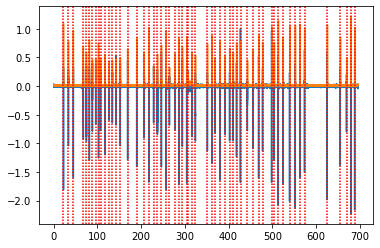

Number of EMG onsets detected: 57



OpenBCI-RAW-2021-07-23_12-34-06.txt


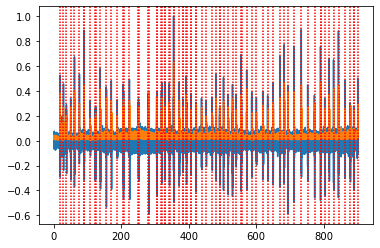

Number of EMG onsets detected: 77



OpenBCI-RAW-2021-07-23_11-58-23.txt


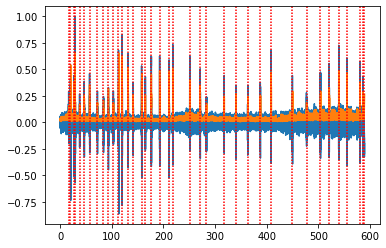

Number of EMG onsets detected: 38



OpenBCI-RAW-2021-07-20_17-28-55.txt


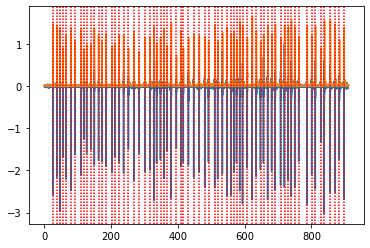

Number of EMG onsets detected: 70





In [74]:
# plot EMG data & RMS for each session
bin_size = 0.050 # sec

for i in range(len(sessions)):
    this_sesh = sessions[i]
    if this_sesh.use:
        print(this_sesh.filename)
        this_sesh.EMG_data = this_sesh.data_chns[-1]
        X = np.linspace(0, math.floor(len(this_sesh.EMG_data)/this_sesh.sample_rate), len(this_sesh.EMG_data))
        Y = this_sesh.EMG_data
        Y = Y/np.max(Y)
        RMS, t_RMS = moving_rms(Y, this_sesh.sample_rate, bin_size)
        plt.plot(X, Y)
        plt.plot(t_RMS, RMS)

        # detect movement onset
        RMS_as_array = np.array(RMS)
        EMG_bool_by_bin =(np.diff((RMS_as_array>threshold).astype(int))==1) #index in seconds

        this_sesh.onsets = []

        for i in range(len(EMG_bool_by_bin)):
            if EMG_bool_by_bin[i] == True:
                if(len(this_sesh.onsets)>0):
                    if((t_RMS[i]-this_sesh.onsets[-1])>1.0):#don't allow two triggers in 1 second
                        this_sesh.onsets.append(t_RMS[i]) #update this so it doesn't add an onset that is in the last 5 seconds or the first 5 seconds
                else:
                    this_sesh.onsets.append(t_RMS[i])

        for i in range(len(this_sesh.onsets)):
            plt.axvline(this_sesh.onsets[i], color='red', dashes=[1,1])

        plt.show()
        print('Number of EMG onsets detected: ' + str(len(this_sesh.onsets)))
        print('\n\n')

## Plot All Session Averages for Specifed Locations

In [75]:
# Make Epochs for Each Location
LOCATION_EPOCHS = [('C3',[]), ('Cz',[]), ('C4',[]), ('O1',[])]
# LOCATION_EPOCHS = [('right arm',[])]

for k in range(len(LOCATION_EPOCHS)):
    epochs = []
    for m in range(1, len(ch_locs)+1):
        if ch_locs[m] == LOCATION_EPOCHS[k][0]:
            ch_idx = m - 1
    for i in range(len(sessions)):
        if sessions[i].use:
            this_sesh = sessions[i]
            for j in range(len(this_sesh.onsets)):
                # print the sessions[i].data_chns index of the current location
                if this_sesh.hrdwr.gen_hrdwr == 'BYB':
                    this_epoch = this_sesh.data_chns[0][math.floor(this_sesh.onsets[j]* this_sesh.sample_rate - (t_pre_onset * this_sesh.sample_rate)) : math.floor(this_sesh.onsets[j]* this_sesh.sample_rate + (t_post_onset * this_sesh.sample_rate))]
                    this_epoch = list(signal.decimate(this_epoch, 40))

                else:
                    this_epoch = list(this_sesh.data_chns[ch_idx][math.floor(this_sesh.onsets[j]* this_sesh.sample_rate - (t_pre_onset * this_sesh.sample_rate)) : math.floor(this_sesh.onsets[j]* this_sesh.sample_rate + (t_post_onset * this_sesh.sample_rate))])

            if len(this_epoch) == 500:
                LOCATION_EPOCHS[k][1].append(this_epoch)

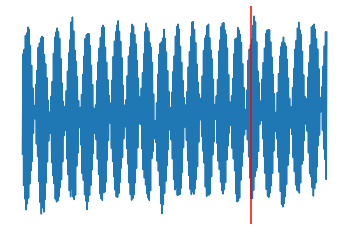

In [76]:
# plot C3
avg = np.mean(LOCATION_EPOCHS[0][1], axis=0)

X = np.linspace(-t_pre_onset, t_post_onset, 500)
Y = avg
plt.plot(X, Y)
plt.axis('off')
plt.axvline(0, color='red')

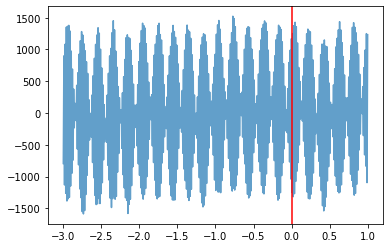

In [77]:
# plot Cz
avg = np.mean(LOCATION_EPOCHS[1][1], axis=0)

X = np.linspace(-t_pre_onset, t_post_onset, 500)
Y = avg
plt.plot(X, Y, alpha=0.7)
# plt.axis('off')
plt.axvline(0, color='red')

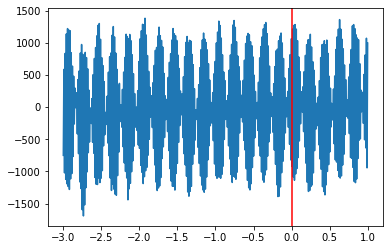

In [78]:
# plot O1
avg = np.mean(LOCATION_EPOCHS[2][1], axis=0)

X = np.linspace(-t_pre_onset, t_post_onset, 500)
Y = avg
plt.plot(X, Y)
# plt.axis('off')
plt.axvline(0, color='red')

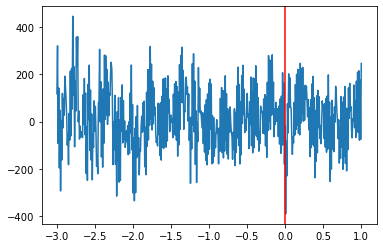

In [79]:
# plot C3-C4
avg_target = np.mean(LOCATION_EPOCHS[0][1], axis=0)

avg_ref = np.mean(LOCATION_EPOCHS[2][1], axis=0)

X = np.linspace(-t_pre_onset, t_post_onset, 500)
Y = avg_target - avg_ref
plt.plot(X, Y)
# plt.axis('off')
plt.axvline(0, color='red')

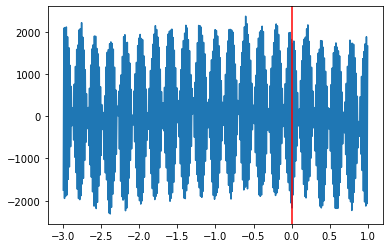

In [80]:
# plot C3-O1
avg_target = np.mean(LOCATION_EPOCHS[0][1], axis=0)

avg_ref = np.mean(LOCATION_EPOCHS[3][1], axis=0)

X = np.linspace(-t_pre_onset, t_post_onset, 500)
Y = avg_target - avg_ref
plt.plot(X, Y)
# plt.axis('off')
plt.axvline(0, color='red')